<a href="https://colab.research.google.com/github/abbaspouraa/Automated-Cardiac-Diagnosis/blob/main/2D_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
all_img = sorted (glob.glob('/content/drive/MyDrive/Data/CardioData/Dataset/training/*/*frame*.nii.gz'))
mask_list = sorted (glob.glob('/content/drive/MyDrive/Data/CardioData/Dataset/training/*/*gt.nii.gz'))
img_list = [img for img in all_img if img not in mask_list]

In [ ]:
# import cv2
# SLICE_DECIMATE_IDENTIFIER = 3

# def saveSlice(img, fname, path, norm=False):
#         if norm:
#             img = np.uint8(img * 255)
            
#         fout = os.path.join(path, f'{fname}.png')
#         cv2.imwrite(fout, img)

# def sliceAndSaveVolumeImage(vol, fname, path, norm=False):
#     (dimx, dimy, dimz) = vol.shape
#     cnt = 0
#     cnt+= dimz
#     for i in range (dimz):
#         saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path, norm)

# import nibabel as nib
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# imageSliceOutput = '/content/drive/MyDrive/Data/CardioData/Preprocessed_Data/image'
# maskSliceOutput = '/content/drive/MyDrive/Data/CardioData/Preprocessed_Data/mask'

# for img in range (len(img_list)):
#     print ("Now we are preparong images and masks: ", img)
    
#     image = nib.load(img_list[img]).get_fdata()
#     image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
#     sliceAndSaveVolumeImage(image, 'patient'+str((img)//2)+str(img%2), imageSliceOutput, norm=True)
    
    
#     mask = nib.load(mask_list[img]).get_fdata()
# #     mask = scaler.fit_transform(mask.reshape(-1, mask.shape[-1])).reshape(mask.shape)
#     mask = mask.astype(np.uint8)
#     sliceAndSaveVolumeImage(mask, 'patient'+str((img)//2)+str(img%2), maskSliceOutput, norm=False)

In [ ]:
import cv2
train_image = []
for directory_path in glob.glob('/content/drive/MyDrive/Data/CardioData/Preprocessed_Data/image'):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path,0)
        if img is None:
            print("None")
        else:
            img = cv2.resize(img,dsize=(256,256))
            train_image.append(img)
train_image = np.array(train_image)

In [ ]:
train_mask = []
for directory_path in glob.glob('/content/drive/MyDrive/Data/CardioData/Preprocessed_Data/mask'):
    for msk_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(msk_path,0)
        if mask is None:
            print("None")
        else:
            mask = cv2.resize(mask,dsize=(256,256), interpolation = cv2.INTER_NEAREST)
            train_mask.append(mask)
train_mask = np.array(train_mask)

In [ ]:
from tensorflow.keras.utils import normalize

print(train_image.shape)
train_image = np.expand_dims(train_image, axis = 3)
print(train_image.shape)
train_image = normalize(train_image, axis=1)
train_mask = np.expand_dims(train_mask, axis = 3)

(1902, 256, 256)
(1902, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_image, train_mask, test_size=100, random_state=0)

In [ ]:
n_classes = 4

train_mask_cat = to_categorical(y_train,num_classes=n_classes)
y_train_cat = train_mask_cat.reshape((y_train.shape[0],y_train.shape[1],y_train.shape[2], n_classes))

test_mask_cat = to_categorical(y_test,num_classes=n_classes)
y_test_cat = test_mask_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
# Data augmetation
from keras.preprocessing.image import ImageDataGenerator

seed = 24

img_data_gen_args = dict(rotation_range=180,
                    #  width_shift_range=0.3,
                    #  height_shift_range=0.3,
                    #  shear_range=0.5,
                     zoom_range=0.2,
                     horizontal_flip=False,
                     vertical_flip=False,
                    fill_mode='constant')

mask_data_gen_args = dict(rotation_range=180,
                    #  width_shift_range=0.3,
                    #  height_shift_range=0.3,
                    #  shear_range=0.5,
                     zoom_range=0.2,
                     horizontal_flip=False,
                     vertical_flip=False,
                     fill_mode='constant',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=32)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train_cat, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train_cat, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test_cat, seed=seed, batch_size=32)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

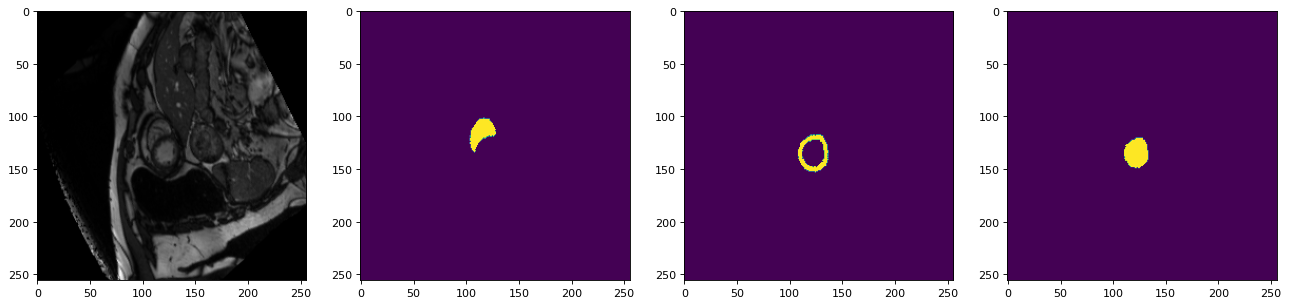

In [ ]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.figure(figsize=(20, 15), dpi=80)
    plt.subplot(1,4,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,4,2)
    plt.imshow(mask[:,:,1])
    plt.subplot(1,4,3)
    plt.imshow(mask[:,:,2])
    plt.subplot(1,4,4)
    plt.imshow(mask[:,:,3])
    plt.show()

In [ ]:
## 2D U-Net Model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, UpSampling2D,concatenate,Conv2DTranspose,BatchNormalization, Dropout,Lambda


def multiClass_UNet_Model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    c1 = Conv2D(16, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(inputs)
    # Batch norm
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(32, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c2)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(64, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c3)
    p3 = MaxPooling2D((2,2))(c3)
    
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer= 'he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer= 'he_normal', padding= 'same')(c4)
    p4 = MaxPooling2D((2,2))(c4)
    
    c5 = Conv2D(256, (3,3), activation= 'relu', kernel_initializer='he_normal', padding= 'same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    u6 = Conv2DTranspose(128, (2,2), strides= (2,2), padding= 'same')(c5)
    #Upsampling
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c6)
    
    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding= 'same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding= 'same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(c8)
    
    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding= 'same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer= 'he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding= 'same')(c9)
    
    outputs = Conv2D(n_classes, (1,1), activation= 'softmax')(c9)
    
    model = Model(inputs= [inputs], outputs= [outputs])
    
    return model

In [ ]:
from keras import backend as K


def DICE(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
  return 2*intersection/(union+intersection)

def IoU(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
  return intersection/union


# Cross enthropy for loss function

def DICE4(y_true, y_pred):
  dice = 0
  for i in range(1,4):
    dice += DICE(y_true[:,:,:,i], y_pred[:,:,:,i])
  return dice/3

def IoU4(y_true, y_pred):
  iou = 0
  for i in range(1,4):
    iou += IoU(y_true[:,:,:,i], y_pred[:,:,:,i])
  return iou/3

def DICE_loss4(y_true, y_pred):
  return (1-DICE4(y_true, y_pred))**2

def IoU_loss4(y_true, y_pred):
  return (1-IoU4(y_true, y_pred))**2

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval. 
filepath="/content/drive/MyDrive/Data/CardioData/saved_models/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]
# callbacks_list = [early_stop]

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


model = multiClass_UNet_Model(n_classes = n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss=[DICE_loss4], metrics=[DICE4])
# model.summary()

history = model.fit(my_generator,  steps_per_epoch=200, validation_steps=80, epochs=50,
                    validation_data=validation_datagen, shuffle=False,
                    callbacks = callbacks_list)
model.save('/content/drive/MyDrive/Data/CardioData/saved_models/Cardio_segmentation_model.h5')

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.5483 - DICE4: 0.2786
Epoch 00001: val_loss improved from 0.43184 to 0.26221, saving model to /content/drive/MyDrive/Data/CardioData/saved_models/weights-improvement-01-0.26.hdf5
200/200 [==============================] - 172s 856ms/step - loss: 0.5483 - DICE4: 0.2786 - val_loss: 0.2622 - val_DICE4: 0.4794
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.1191 - DICE4: 0.6669
Epoch 00002: val_loss improved from 0.26221 to 0.05938, saving model to /content/drive/MyDrive/Data/CardioData/saved_models/weights-improvement-02-0.06.hdf5
200/200 [==============================] - 167s 838ms/step - loss: 0.1191 - DICE4: 0.6669 - val_loss: 0.0594 - val_DICE4: 0.7644
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.0492 - DICE4: 0.7829
Epoch 00003: val_loss did not improve from 0.05938
200/200 [==============================] - 170s 856ms/step - loss: 0.0492 - DICE4: 0.7829 - val_lo

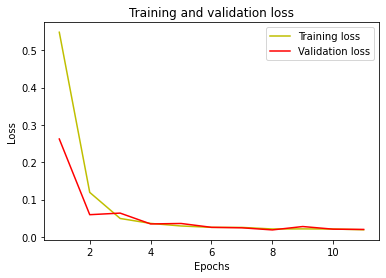

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

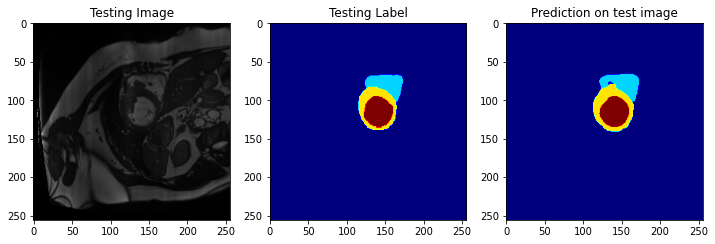

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()